In [53]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from sklearn.externals import joblib
import MySQLdb as mdb

import sys 
sys.path.append('..')
from algo import generateHeader

In [54]:
con = mdb.connect(host="127.0.0.1", port=3306, user="stalker", passwd="baddy", db="canvas_fp_project")
cur = con.cursor(mdb.cursors.DictCursor)

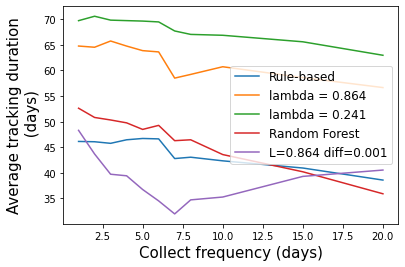

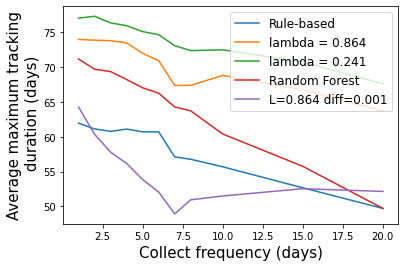

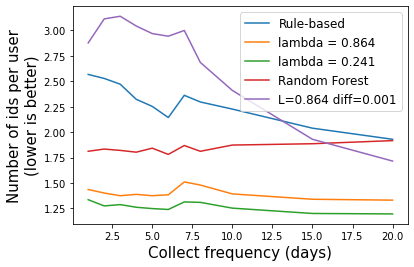

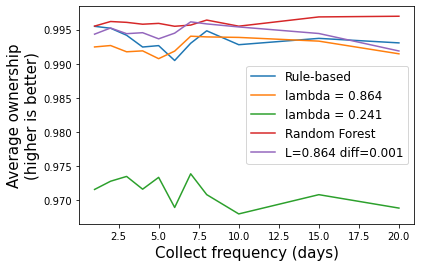

In [73]:
def process_results_replay(experiment, algotype, min_fp_needed):
    file_names = os.listdir("../results/")
    nb_days_to_tracking_time = dict()
    nb_days_to_nb_ids_assigned = dict()
    nb_days_to_nb_fps = dict()
    nb_days_to_max_chain_ratio = dict()
    nb_days_to_ownership = dict()
    nb_days_to_length_chain = dict()
    nb_days_to_nb_raw_days = dict()
    nb_days_to_acc = dict()
    nb_days_to_nb_ids_user = dict()
    
    # file format: 
    # {exp_name}-{algo}-{minimum_fp}_{collect_frequency}{-res1/-res2/scenario_replay_result}.csv
    for file_name in file_names:
        if file_name == "README.md":
            continue
        try:
            nb_days = file_name.split("_")[1]
            # special case for 0.5
            if "." in nb_days[:3]:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))/10.0
            else:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        except:
            nb_days = file_name.split("_")[2]
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        
        # nb_days is just collect frequency
        prefix_file = experiment + "-" + algotype + "-" + str(min_fp_needed)
        if prefix_file in file_name:
            df = pd.read_csv("../results/%s" % file_name)
            if "res1" in file_name:
                # we recompute ratio so that the first fingerprint of each assigned id is not counted
                df["ratio"] = (df["nb_original_fp"] - df["nb_assigned_ids"])/df["nb_assigned_ids"]
                df["nb_raw_days"] = df["ratio"] * nb_days
                df["nb_days"] = df["ratio"]/df["nb_original_fp"]
                df["max_chain_ratio"] = (df["max_chain"]-1)*nb_days
                df["acc"] = 1.0/df["nb_assigned_ids"]
                nb_days_to_tracking_time[nb_days] = np.mean(df["nb_days"])
                nb_days_to_max_chain_ratio[nb_days] = np.mean(df["max_chain_ratio"])
                nb_days_to_nb_raw_days[nb_days] = np.mean(df["nb_raw_days"])
                nb_days_to_acc[nb_days] = np.mean(df["acc"])
                nb_days_to_nb_ids_user[nb_days] = np.mean(df["nb_assigned_ids"])
            elif "res2" in file_name:
                nb_days_to_nb_ids_assigned[nb_days] = np.mean(df["nb_assigned_ids"])
                nb_days_to_ownership[nb_days] = np.mean(df["ownership"])
                nb_days_to_length_chain[nb_days] = np.mean(df["nb_fingerprints"])
            elif "replay" in file_name:
                nb_days_to_nb_fps[nb_days] = len(df)
    
    pandas_dict = {
        "nb_days": [],
        "nb_raw_days": [],
        "tracking_time": [],
        "nb_ids_assigned": [],
        "nb_fps": [],
        "max_chain_ratio": [],
        "length_chain": [],
        "ownership": [],
        "acc": [],
        "nb_days_to_nb_ids_user": []
        
    }
    
    for nb_days in nb_days_to_tracking_time:
        pandas_dict["nb_days"].append(nb_days)
        pandas_dict["tracking_time"].append(nb_days_to_tracking_time[nb_days])
        pandas_dict["nb_raw_days"].append(nb_days_to_nb_raw_days[nb_days])
        pandas_dict["nb_ids_assigned"].append(nb_days_to_nb_ids_assigned[nb_days])
        pandas_dict["nb_fps"].append(nb_days_to_nb_fps[nb_days])
        pandas_dict["max_chain_ratio"].append(nb_days_to_max_chain_ratio[nb_days])
        pandas_dict["length_chain"].append(nb_days_to_length_chain[nb_days])
        pandas_dict["ownership"].append(nb_days_to_ownership[nb_days])
        pandas_dict["acc"].append(nb_days_to_acc[nb_days])
        pandas_dict["nb_days_to_nb_ids_user"].append(nb_days_to_nb_ids_user[nb_days])
    return pd.DataFrame(pandas_dict).sort_values("nb_days")

def plot_data(df_label_list, x_name, y_name, x_label, y_label, save_loc):
    lines = []
    for df, label in df_label_list:
        x = df[x_name]
        y = df[y_name]
        line, = plt.plot(x, y, label=label)
        lines.append(line)

    plt.xlabel(x_label, fontsize=15)        
    plt.ylabel(y_label, fontsize=15)

    plt.legend(handles=lines, loc=0, fontsize=12)
    plt.savefig(save_loc, bbox_inches = 'tight')
    plt.show()

def plot_data_from_list(df_label_list):    
    # plot 1: nb_days vs nb_raw_days
    plot_data(df_label_list, "nb_days", "nb_raw_days", 
                'Collect frequency (days)', 'Average tracking duration\n (days)',
                './raw_days_frequency.pdf')

    # plot 2: nb_days vs max_chain_ratio
    plot_data(df_label_list, "nb_days", "max_chain_ratio", 
                'Collect frequency (days)', 'Average maximum tracking\n duration (days)',
                './raw_max_days_frequency.pdf')

    # plot 3: nb_days vs nb_day_to_nb_ids_user
    plot_data(df_label_list, "nb_days", "nb_days_to_nb_ids_user", 
                'Collect frequency (days)', 'Number of ids per user\n(lower is better)',
                './raw_max_days_frequency.pdf')

    # plot 4: nb_days vs ownership
    plot_data(df_label_list, "nb_days", "ownership", 
                'Collect frequency (days)', 'Average ownership\n(higher is better)',
                './ownership_frequency.pdf')

df_rule = process_results_replay("logreg", "rulebased", 6)
df_ml = process_results_replay("lambda0.864", "hybridalgo", 6)
df_l241 = process_results_replay("nnlambda0.241", "hybridalgo", 6)
df_rf =  process_results_replay("randforest", "hybridalgo", 6)
df_l864_d01 = process_results_replay("nnl864diff001", "hybridalgo", 6)


plot_data_from_list([(df_rule, "Rule-based"), (df_ml, "lambda = 0.864"),
                    (df_l241, "lambda = 0.241"),
                    (df_rf, "Random Forest"),
                    (df_l864_d01, "L=0.864 diff=0.001")])


In [ ]:
def process_results_replay(prefix_file):
    file_names = os.listdir("../results/")
    nb_days_to_tracking_time = dict()
    nb_days_to_nb_ids_assigned = dict()
    nb_days_to_nb_fps = dict()
    nb_days_to_max_chain_ratio = dict()
    nb_days_to_ownership = dict()
    nb_days_to_length_chain = dict()
    nb_days_to_nb_raw_days = dict()
    nb_days_to_acc = dict()
    nb_days_to_nb_ids_user = dict()
    
    # file format: 
    # {exp_name}-{algo}-{minimum_fp}_{collect_frequency}{-res1/-res2/scenario_replay_result}.csv
    for file_name in file_names:
        if file_name == "README.md":
            continue
        try:
            nb_days = file_name.split("_")[1]
            # special case for 0.5
            if "." in nb_days[:3]:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))/10.0
            else:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        except:
            nb_days = file_name.split("_")[2]
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        
        # nb_days is just collect frequency
        print(file_name)
        if prefix_file in file_name:
            df = pd.read_csv("../results/%s" % file_name)
            if "res1" in file_name:
                # we recompute ratio so that the first fingerprint of each assigned id is not counted
                df["ratio"] = (df["nb_original_fp"] - df["nb_assigned_ids"])/df["nb_assigned_ids"]
                df["nb_raw_days"] = df["ratio"] * nb_days
                df["nb_days"] = df["ratio"]/df["nb_original_fp"]
                df["max_chain_ratio"] = (df["max_chain"]-1)*nb_days
                df["acc"] = 1.0/df["nb_assigned_ids"]
                nb_days_to_tracking_time[nb_days] = np.mean(df["nb_days"])
                nb_days_to_max_chain_ratio[nb_days] = np.mean(df["max_chain_ratio"])
                nb_days_to_nb_raw_days[nb_days] = np.mean(df["nb_raw_days"])
                nb_days_to_acc[nb_days] = np.mean(df["acc"])
                nb_days_to_nb_ids_user[nb_days] = np.mean(df["nb_assigned_ids"])
            elif "res2" in file_name:
                nb_days_to_nb_ids_assigned[nb_days] = np.mean(df["nb_assigned_ids"])
                nb_days_to_ownership[nb_days] = np.mean(df["ownership"])
                nb_days_to_length_chain[nb_days] = np.mean(df["nb_fingerprints"])
            elif "replay" in file_name:
                nb_days_to_nb_fps[nb_days] = len(df)
    
    pandas_dict = {
        "nb_days": [],
        "nb_raw_days": [],
        "tracking_time": [],
        "nb_ids_assigned": [],
        "nb_fps": [],
        "max_chain_ratio": [],
        "length_chain": [],
        "ownership": [],
        "acc": [],
        "nb_days_to_nb_ids_user": []
        
    }
    
    for nb_days in nb_days_to_tracking_time:
        pandas_dict["nb_days"].append(nb_days)
        pandas_dict["tracking_time"].append(nb_days_to_tracking_time[nb_days])
        pandas_dict["nb_raw_days"].append(nb_days_to_nb_raw_days[nb_days])
        pandas_dict["nb_ids_assigned"].append(nb_days_to_nb_ids_assigned[nb_days])
        pandas_dict["nb_fps"].append(nb_days_to_nb_fps[nb_days])
        pandas_dict["max_chain_ratio"].append(nb_days_to_max_chain_ratio[nb_days])
        pandas_dict["length_chain"].append(nb_days_to_length_chain[nb_days])
        pandas_dict["ownership"].append(nb_days_to_ownership[nb_days])
        pandas_dict["acc"].append(nb_days_to_acc[nb_days])
        pandas_dict["nb_days_to_nb_ids_user"].append(nb_days_to_nb_ids_user[nb_days])
    return pd.DataFrame(pandas_dict).sort_values("nb_days")


def plot_data(df_label_list):    
    # plot 1: nb_days vs nb_raw_days
    lines = []
    for df, label in df_label_list:
        x = df["nb_days"]
        y = df["nb_raw_days"]
        lines.append(plt.plot(x, y, label=label))
        
    plt.ylabel('Average tracking duration\n (days)', fontsize=15)
    plt.xlabel('Collect frequency (days)', fontsize=15)
    plt.legend(handles=lines, loc=0, fontsize=12)
    plt.savefig('./raw_days_frequency.pdf', bbox_inches = 'tight')
    plt.show()

    # plot 2: nb_days vs max_chain_ratio
    lines = []
    for df, label in df_label_list:
        x = df["nb_days"]
        y = df["max_chain_ratio"]
        lines.append(plt.plot(x, y, label=label))
        
    plt.ylabel('Average maximum tracking\n duration (days)', fontsize=15)
    plt.xlabel('Collect frequency (days)', fontsize=15)
    plt.legend(handles=lines, loc=0, fontsize=12)
    plt.savefig('./raw_max_days_frequency.pdf', bbox_inches = 'tight')
    plt.show()
    
    # plot 3: nb_days vs nb_day_to_nb_ids_user
    lines = []
    for df, label in df_label_list:
        x = df["nb_days"]
        y = df["nb_days_to_nb_ids_user"]
        lines.append(plt.plot(x, y, label=label))
    plt.ylabel('Number of ids per user\n(lower is better)', fontsize=15)
    plt.xlabel('Collect frequency (days)', fontsize=15)
    plt.legend(handles=lines, loc=0, fontsize=12)
    plt.savefig('./nb_ids_frequency.pdf', bbox_inches = 'tight')
    plt.show()
    
    # plot 4: nb_days vs ownership
    lines = []
    for df, label in df_label_list:
        x = df["nb_days"]
        y = df["ownership"]
        lines.append(plt.plot(x, y, label=label))
    plt.ylabel('Average ownership\n(higher is better)', fontsize=15)
    plt.xlabel('Collect frequency (days)', fontsize=15)
    plt.legend(handles=lines, loc=0, fontsize=12)
    plt.savefig('./ownership_frequency.pdf', bbox_inches = 'tight')
    plt.show()

df_eck = process_results_replay("eck")
df_rule = process_results_replay("rule")
df_ml = process_results_replay("hybrid")

plot_data([(df_eck, "Panopticlick"), (df_rule, "Rule-based"), (df_ml, "Hybrid")])


In [34]:
file_names = os.listdir("../results/")
nb_days_to_tracking_time = dict()
nb_days_to_nb_ids_assigned = dict()
nb_days_to_nb_fps = dict()
nb_days_to_max_chain_ratio = dict()
nb_days_to_ownership = dict()
nb_days_to_length_chain = dict()
nb_days_to_nb_raw_days = dict()
nb_days_to_acc = dict()
nb_days_to_nb_ids_user = dict()


prefix_file="eck"
# file format: 
# {exp_name}-{algo}-{minimum_fp}_{collect_frequency}{-res1/-res2/scenario_replay_result}.csv
for file_name in file_names:
    if file_name == "README.md":
        continue
    try:
        nb_days = file_name.split("_")[1]
        # special case for 0.5
        if "." in nb_days[:3]:
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))/10.0
        else:
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))
    except:
        nb_days = file_name.split("_")[2]
        nb_days = float("".join(re.findall('\d+', nb_days[:3])))

    # nb_days is just collect frequency
    if prefix_file in file_name:
        df = pd.read_csv("../results/%s" % file_name)
        if "res1" in file_name:
            # we recompute ratio so that the first fingerprint of each assigned id is not counted
            df["ratio"] = (df["nb_original_fp"] - df["nb_assigned_ids"])/df["nb_assigned_ids"]
            df["nb_raw_days"] = df["ratio"] * nb_days
            df["nb_days"] = df["ratio"]/df["nb_original_fp"]
            df["max_chain_ratio"] = (df["max_chain"]-1)*nb_days
            df["acc"] = 1.0/df["nb_assigned_ids"]
            nb_days_to_tracking_time[nb_days] = np.mean(df["nb_days"])
            nb_days_to_max_chain_ratio[nb_days] = np.mean(df["max_chain_ratio"])
            nb_days_to_nb_raw_days[nb_days] = np.mean(df["nb_raw_days"])
            nb_days_to_acc[nb_days] = np.mean(df["acc"])
            nb_days_to_nb_ids_user[nb_days] = np.mean(df["nb_assigned_ids"])
        elif "res2" in file_name:
            nb_days_to_nb_ids_assigned[nb_days] = np.mean(df["nb_assigned_ids"])
            nb_days_to_ownership[nb_days] = np.mean(df["ownership"])
            nb_days_to_length_chain[nb_days] = np.mean(df["nb_fingerprints"])
        elif "replay" in file_name:
            nb_days_to_nb_fps[nb_days] = len(df)
df = pd.read_csv("../results/%s" % "first_experiment-rulebased-6_10scenario_replay_result.csv")
df

,6122_i,02c03116-e6ec-4df5-8bc3-8589e105743e
0,6123_i,d0e9d996-9144-462f-af31-0e3d74b86cfe
1,6126_i,87581193-74e2-45f8-91d3-0008b0864cb9
2,6127_i,1c19fac8-5dd7-47cd-b0e7-820cc772fd86
3,6128_i,03fe217e-a8c9-483a-b285-feaaaa148083
4,6129_i,769ba544-7792-4be4-a28b-676a40714800
...,...,...
2012,14731_0,1ac7ffd1-79e4-4538-bc30-d1c4550da309
2013,14613_0,96440c4a-ab24-44a4-b9da-a281d5b74b57
2014,14838_0,94c23b78-e4db-4f11-a0b1-e0b699d6e6e6
2015,14923_0,5bae5952-18c5-48a2-a6de-566a1b4d12be


1.0 229
10.0 229
15.0 229
2.0 229
20.0 229
3.0 229
4.0 229
5.0 229
6.0 229
7.0 229
8.0 229
1.0 229
10.0 229
15.0 229
2.0 229
20.0 229
3.0 229
4.0 229
5.0 229
6.0 229
7.0 229
8.0 229


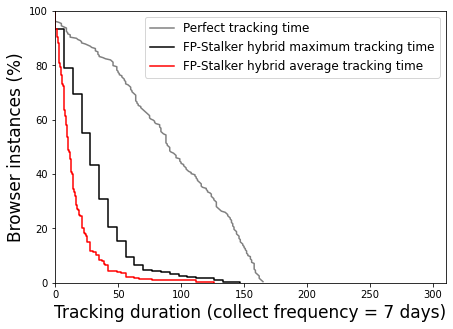

9.0


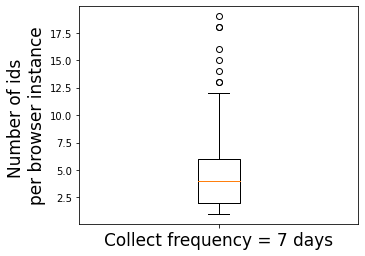

1.0


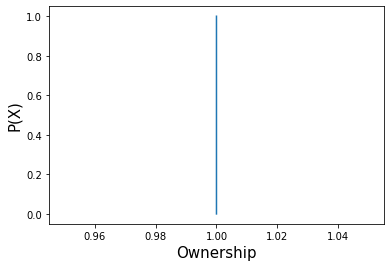

In [4]:
def get_results_details(prefix_file):
    file_names = os.listdir("../results/")
    nb_days_to_df1 = dict()
    nb_days_to_df2 = dict()
    for file_name in file_names:
        if file_name == "README.md":
            continue
        try:
            nb_days = file_name.split("_")[1]
            # special case for 0.5
            if "." in nb_days[:3]:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))/10.0
            else:
                nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        except:
            nb_days = file_name.split("_")[2]
            nb_days = float("".join(re.findall('\d+', nb_days[:3])))
        
        if prefix_file in file_name:
            df = pd.read_csv("../results/%s" % file_name)
            if "res1" in file_name:
                print(nb_days, len(df))
                # we recompute ratio so that the first fingerprint of each assigned id is not counted
                df["ratio"] = (df["nb_original_fp"] - df["nb_assigned_ids"])/df["nb_assigned_ids"]
                df["nb_raw_days"] = df["ratio"] * nb_days
                df["nb_days"] = df["ratio"]/df["nb_original_fp"]
                df["max_chain_ratio"] = (df["max_chain"]-1)*nb_days
                df["acc"] = 1.0/df["nb_assigned_ids"]
                nb_days_to_df1[nb_days] = df
            elif "res2" in file_name:
                nb_days_to_df2[nb_days] = df

    return nb_days_to_df1, nb_days_to_df2


nb_days_to_df1, nb_days_to_df2 = get_results_details("hybrid")

df_7 = nb_days_to_df1[7]

# we plot ground truth on same graph

with open("../data/consistent_extension_ids.csv", "r") as f:
    # we jump header
    f.readline()
    ids_query = []

    for line in f.readlines():
        ids_query.append("'" + line.replace("\n", "") + "'")
    
ids_query = ",".join(ids_query)

#172781
# check if 7 or 6
cur.execute("SELECT creationDate, id FROM extensiondatascheme WHERE counter < 199910 and \
                id in ("+ids_query+") and \
                id in (SELECT id FROM extensiondatascheme GROUP BY \
                id having count(*) > 6)\
                ORDER by counter ASC")

fps = cur.fetchall()
index_split = int(len(fps)*0.4)
# train, test
fps = fps[index_split:]

user_id_to_fps = {}

for fp in fps:
    try:
        user_id_to_fps[fp["id"]].append(fp["creationDate"])
    except:
        user_id_to_fps[fp["id"]] = [fp["creationDate"]]


durations = []
p = []
current_p = 100

for user_id in user_id_to_fps:
    fps = user_id_to_fps[user_id]
    duration_user = (fps[-1] - fps[0]).days
    durations.append(duration_user)
    p.append(current_p)
    current_p -= 100.0/(len(user_id_to_fps))


durations.sort(reverse=False)
plt.figure(figsize=(7, 5))
lref, = plt.plot(durations, p, label="Perfect tracking time", color="gray")

data = df_7["max_chain_ratio"].sort_values(ascending=False)
data2 = df_7["nb_raw_days"].sort_values(ascending=False)

cum_dist = np.linspace(0.,100.0,len(data))
ser_cdf = pd.Series(cum_dist, index=data)
ser_cdf2 = pd.Series(cum_dist, index=data2)
plt.ylabel('Browser instances (%)', fontsize=17)
plt.xlabel('Tracking duration (collect frequency = 7 days)', fontsize=17)
plt.xlim([0, 310])
plt.ylim([0, 100])
line_ser, = plt.plot(ser_cdf, drawstyle='steps', label="FP-Stalker hybrid maximum tracking time", color="black")
line_ser2, = plt.plot(ser_cdf2, drawstyle='steps', label="FP-Stalker hybrid average tracking time", color="red")
plt.legend(handles=[lref, line_ser, line_ser2], loc=0, fontsize=12)

# print(len(ser_cdf))
# print(len(ser_cdf2))
# print(len(durations))

with open('durations.csv', 'w+') as f:
    f.write("duration,p\n")
    for idx in range(len(durations)):
        f.write("{:f},{:f}\n".format(durations[idx], p[idx]))
# with open('./cdf_tracking_time.csv', "w+") as f:
    

# plt.savefig('./cdf_tracking_time.pdf', bbox_inches = 'tight')
plt.savefig('./cdf_tracking_time_inverse.pdf', bbox_inches = 'tight')

plt.show()

data_ids = df_7["nb_assigned_ids"].sort_values()
print(np.percentile(data_ids, 90))
cum_dist = np.linspace(0.,1.,len(data_ids))
ser_cdf_ids = pd.Series(cum_dist, index=data_ids)
plt.figure(figsize=(5, 4))
plt.ylabel('Number of ids \nper browser instance', fontsize=17)
plt.boxplot(data_ids)
plt.xticks([1], ['Collect frequency = 7 days'], fontsize=17)
plt.savefig('./boxplot_nb_ids.pdf', bbox_inches = 'tight')
plt.show()


df2_7 = nb_days_to_df2[7]
data_ownership = df2_7["ownership"].sort_values()
print(np.percentile(data_ownership, 90))
cum_dist2 = np.linspace(0.,1.,len(data_ownership))
ser_cdf_ownership = pd.Series(cum_dist2, index=data_ownership)
plt.ylabel('P(X)', fontsize=15)
plt.xlabel('Ownership', fontsize=15)
plt.plot(ser_cdf_ownership, drawstyle='steps')
plt.savefig('./cdf_ownership.pdf')
plt.show()

In [5]:
header = ['canvasJSHashed', 'creationDate', 'hasFlash', 'sameFonts', 'languageHttp', 'simPlugs', 'rendererWebGLJS', 'resolutionJS', 'timezoneJS', 'userAgentHttp', 'nbChange']
model = joblib.load("../data/my_ml_model")
importances = model.feature_importances_
print(len(model.estimators_[0].feature_importances_))
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(len(indices))
print(len(header))

name_attributes = header

# Print the feature ranking
print("Feature ranking:")
for f in range(len(name_attributes)):
    print("%d. feature %s (%f)" % (f + 1, name_attributes[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(name_attributes)), importances[indices],
       color="r", yerr=std[indices], align="center")
labels_to_keep = [name_attributes[x] for x in indices]
plt.xticks(range(len(name_attributes)), labels_to_keep)
plt.xlim([-1, 5.5])
plt.show()

AttributeError: 'LogisticRegressionCV' object has no attribute 'feature_importances_'